# Impact Studies Using SuPy in Parallel Mode

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` in a parallel mode to investigate the impacts on urban climate of

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



## Prepare `supy` for the parallel mode

### load `supy` and sample dataset

In [1]:
from dask import delayed
from dask import dataframe as dd
import os
import supy as sp
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import time

get_ipython().run_line_magic('matplotlib', 'inline')
# produce high-quality figures, which can also be set as one of ['svg', 'pdf', 'retina', 'png']
# 'svg' produces high quality vector figures
%config InlineBackend.figure_format = 'svg'
print('version info:')
print('supy:', sp.__version__)
print('supy_driver:', sp.__version_driver__)

version info:
supy: 2019.2.8
supy_driver: 2018c5


In [2]:
# load sample datasets
df_state_init, df_forcing = sp.load_SampleData()
# perform an example run to get output samples for later use
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)


### Paralell setup for `supy` using `dask`

In addition to the above packages, we also load `dask` to enable `supy` run in a parallel mode. Specifically, we will use [`dask.dataframe`](http://docs.dask.org/en/latest/dataframe.html), a specialized `dataframe` extending `pandas.DataFrame`'s ability in parallel operations, to implement a parallel `supy` for the impact studies in this tutorial.

Given the nature of impact studies that requires multiple independent models with selected parameters/variables varying across the setups, such simulations well fall into the scope of so-called [*embarrassingly parallel computation*](http://docs.dask.org/en/latest/use-cases.html#embarrassingly-parallel-computation) that is fully supported by `dask`. Also, as `supy` is readily built on the data structure `pandas.DataFrame`, we can fairly easily transfer it to the `dask` framework for parallel operations.

Internally, for a given forcing dataset `df_forcing`, `supy` loops over the grids in a `df_state_init` to conduct simulations. In this case, we can adapt the `df_state_init` to a `dask`-ed version to gain the parallel benefits through its parallelized `apply` method.

`dask.dataframe` essentially divides the work into pieces for parallel operations. As such, depending on the number of processors in your computer, it would be more efficient to set the partition number as the multipliers of CPU numbers.

In [5]:
import platform
import psutil
list_info=['machine','system','mac_ver','processor']
for info in list_info:
    info_x=getattr(platform,info)()
    print(info,':',info_x)
cpu_count=psutil.cpu_count()
print('number of CPU processors:',cpu_count)
mem_size=psutil.virtual_memory().total/1024**3
print('memory size (GB):',mem_size)

machine : x86_64
system : Darwin
mac_ver : ('10.14.3', ('', '', ''), 'x86_64')
processor : i386
number of CPU processors: 12
memory size (GB): 32.0


To demonstrate the parallelization, we simply duplicate the contents in `df_state_init` to make it seemingly large. Note we intentionally choose `24` as the number for copies to accompany the power of CPU.

Before we move on to the parallel mode, we perform a simulation in the traditional serial way to see the baseline performance.

#### Baseline serial  run

In [6]:
# just run for 30 days
df_forcing_part = df_forcing.iloc[:288*30]
df_state_init_mgrids = df_state_init.copy()
# construct a multi-grid `df_state_init`
for i in range(24-1):
    df_state_init_mgrids = df_state_init_mgrids.append(
        df_state_init, ignore_index=True)
# perform a serial run
t0 = time()
xx = sp.run_supy(df_forcing_part, df_state_init_mgrids)
t1 = time()
t_ser = t1-t0
print(f'Execution time: {t_ser:.2f} s')


Execution time: 23.06 s


#### Parallel  run

In [7]:
# convert `pandas.DataFrame` to `dask.dataframe` to enable parallelization
dd_state_init = dd.from_pandas(
    df_state_init_mgrids,
    npartitions=os.cpu_count()*2)

# perform a parallel run using `map_partitions`
t0 = time()
xx_mp = dd_state_init\
    .map_partitions(
        lambda x: sp.run_supy(df_forcing_part, x)[0],
        meta=df_output)\
    .compute(scheduler='processes')
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 7.05 s


Check the data structure of  `xx_mp`:

In [6]:
xx_mp.head()

group                        SUEWS                                    \
var                          Kdown       Kup       Ldown         Lup   
grid datetime                                                          
0    2012-01-01 00:05:00  0.153333  0.018279  344.310184  371.986259   
     2012-01-01 00:10:00  0.153333  0.018279  344.310184  371.986259   
     2012-01-01 00:15:00  0.153333  0.018279  344.310184  371.986259   
     2012-01-01 00:20:00  0.153333  0.018279  344.310184  371.986259   
     2012-01-01 00:25:00  0.153333  0.018279  344.310184  371.986259   

group                                                                \
var                           Tsurf         QN         QF        QS   
grid datetime                                                         
0    2012-01-01 00:05:00  11.775615 -27.541021  40.574001 -46.53243   
     2012-01-01 00:10:00  11.775615 -27.541021  39.724283 -46.53243   
     2012-01-01 00:15:00  11.775615 -27.541021  38.874566 -46.53243   
     2012-01-01 00:20:00  11.775615 -27.541021  38.024849 -46.53243   
     2012-01-01 00:25:00  11.775615 -27.541021  37.175131 -46.53243   

group                                         ...     DailyState  \
var                              QH        QE ... DensSnow_Paved   
grid datetime                                 ...                  
0    2012-01-01 00:05:00  62.420064  3.576493 ...            NaN   
     2012-01-01 00:10:00  61.654096  3.492744 ...            NaN   
     2012-01-01 00:15:00  60.885968  3.411154 ...            NaN   
     2012-01-01 00:20:00  60.115745  3.331660 ...            NaN   
     2012-01-01 00:25:00  59.343488  3.254200 ...            NaN   

group                                                                  \
var                      DensSnow_Bldgs DensSnow_EveTr DensSnow_DecTr   
grid datetime                                                           
0    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                                          \
var                      DensSnow_Grass DensSnow_BSoil DensSnow_Water  a1  a2   
grid datetime                                                                   
0    2012-01-01 00:05:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN NaN NaN   

group                         
var                       a3  
grid datetime                 
0    2012-01-01 00:05:00 NaN  
     2012-01-01 00:10:00 NaN  
     2012-01-01 00:15:00 NaN  
     2012-01-01 00:20:00 NaN  
     2012-01-01 00:25:00 NaN  

[5 rows x 218 columns]

Perform a parallel run using `apply`:

In [8]:
# perform a parallel run using `apply`
t0 = time()
xx_apply = dd_state_init\
    .apply(
        lambda x: sp.run_supy(df_forcing_part, x.to_frame().T)[0],
        axis=1,
        meta=df_output.iloc[0],
    )\
    .compute(scheduler='processes')
t1 = time()
t_par = t1 - t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 9.98 s


Check the data structure of  `xx_apply`.
Note the difference in resulted data structure between `xx_apply` and `xx_mp`:

In [9]:
xx_apply.head()

0    group                        SUEWS            ...
1    group                        SUEWS            ...
2    group                        SUEWS            ...
3    group                        SUEWS            ...
4    group                        SUEWS            ...
Name: (98, 2012-01-01 00:05:00), dtype: object

Wrap up the above code into a function for easier use in multi-grid simulations

In [10]:
# function for multi-grid `run_supy` using map_partitions for better performance
def run_supy_mgrids(df_state_init_mgrids, df_forcing):
    dd_state_init = dd.from_pandas(
        df_state_init_mgrids,
        npartitions=os.cpu_count()*2)
    df_output_mgrids = dd_state_init\
        .map_partitions(
            lambda x: sp.run_supy(df_forcing, x)[0],
            meta=df_output)\
        .compute(scheduler='processes')
    return df_output_mgrids

#### Benchmark test

*Note: this test may take a considerably long time depending on the machine performance*

In [10]:
# different running length
list_sim_len = [
    day * 288 for day in [30, 90, 120, 150, 180, 270, 365, 365 * 2, 365 * 3]
]

# number of test grids 
n_grid = 12

# construct a multi-grid `df_state_init`
df_state_init_m = df_state_init.copy()
for i in range(n_grid - 1):
    df_state_init_m = df_state_init_m.append(df_state_init, ignore_index=True)

# construct a longer`df_forcing` for three years
df_forcing_m = pd.concat([df_forcing for i in range(3)])
df_forcing_m.index = pd.date_range(
    df_forcing.index[0],
    freq=df_forcing.index.freq,
    periods=df_forcing_m.index.size)

dict_time_ser = dict()
dict_time_par = dict()
for sim_len in list_sim_len:
    df_forcing_part = df_forcing_m.iloc[:sim_len]
    print('Sim days:', sim_len / 288)
    print('No. of grids:', df_state_init_m.shape[0])
    # serial run
    print('serial:')
    t0 = time()
    sp.run_supy(df_forcing_part, df_state_init_m)
    t1 = time()
    t_test = t1 - t0
    print(f'Execution time: {t_test:.2f} s')
    #     print()
    dict_time_ser.update({sim_len: t_test})

    # parallel run
    print('parallel:')
    t0 = time()
    run_supy_mgrids(df_state_init_m, df_forcing_part)
    t1 = time()
    t_test = t1 - t0
    print(f'Execution time: {t_test:.2f} s')
    print()
    dict_time_par.update({sim_len: t_test})

Sim days: 30.0
No. of grids: 12
serial:
Execution time: 10.62 s
parallel:
Execution time: 3.99 s

Sim days: 90.0
No. of grids: 12
serial:
Execution time: 37.36 s
parallel:
Execution time: 19.63 s

Sim days: 120.0
No. of grids: 12
serial:
Execution time: 51.14 s
parallel:
Execution time: 28.22 s

Sim days: 150.0
No. of grids: 12
serial:
Execution time: 58.08 s
parallel:
Execution time: 35.20 s

Sim days: 180.0
No. of grids: 12
serial:
Execution time: 67.24 s
parallel:
Execution time: 50.90 s

Sim days: 270.0
No. of grids: 12
serial:
Execution time: 97.64 s
parallel:
Execution time: 63.56 s

Sim days: 365.0
No. of grids: 12
serial:
Execution time: 125.39 s
parallel:
Execution time: 66.33 s

Sim days: 730.0
No. of grids: 12
serial:
Execution time: 250.16 s
parallel:
Execution time: 97.39 s

Sim days: 1095.0
No. of grids: 12
serial:
Execution time: 381.80 s
parallel:
Execution time: 147.22 s



Text(0, 0.5, 'Execution Ratio (=p/s)')

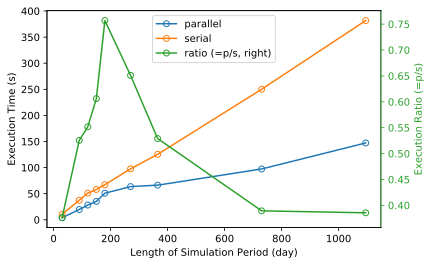

In [11]:
df_benchmark = pd.DataFrame([
    dict_time_par,
    dict_time_ser,
]).T.rename(columns={
    0: 'parallel',
    1: 'serial',
})
df_benchmark.index = (df_benchmark.index / 288).astype(int).set_names(
    'Length of Simulation Period (day)')
# df_benchmark.columns.set_names('Execution Time (s)',inplace=True)
df_benchmark = df_benchmark\
    .assign(
        ratio=df_benchmark['parallel'] / df_benchmark['serial']
    )\
    .rename(columns={'ratio': 'ratio (=p/s, right)'})
# df_benchmark = df_benchmark.drop(index=[1,7,240])
ax = df_benchmark.plot(secondary_y='ratio (=p/s, right)',marker='o',fillstyle='none')

ax.set_ylabel('Execution Time (s)')

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

ax.right_ax.spines['right'].set_color('C2')
ax.right_ax.tick_params(axis='y', colors='C2')
ax.right_ax.set_ylabel('Execution Ratio (=p/s)',color='C2')
# patches,labels=ax.get_legend_handles_labels()

# ax.legend(patches,labels, loc='upper center')

## Surface properties: surface albedo

### Examine the default albedo values loaded from the sample dataset

In [6]:
df_state_init.alb


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0.12,0.15,0.12,0.18,0.21,0.21,0.1


### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

Note: `DataFrame.copy()` defaults to `deepcopy`

In [7]:
df_state_init_test = df_state_init.copy()


### Set the `Bldg` land cover to 100% for this study

In [8]:
df_state_init_test.sfr = 0
df_state_init_test.loc[:, ('sfr', '(1,)')] = 1
df_state_init_test.sfr


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0,1,0,0,0,0,0


### Construct a `df_state_init_x` dataframe to perform `supy` simulation with specified albedo

In [9]:
# create a `df_state_init_x` with different surface properties
n_test = 24
list_alb_test = np.linspace(0.1, 0.8, n_test).round(2)
df_state_init_x = df_state_init_test.append(
    [df_state_init_test]*(n_test-1), ignore_index=True)

# here we modify surface albedo
df_state_init_x.loc[:, ('alb', '(1,)')] = list_alb_test


### Conduct simulations with `supy`

In [14]:
df_forcing_part = df_forcing.loc['2012 01':'2012 07']
df_res_alb_test = run_supy_mgrids(df_state_init_x, df_forcing_part)

In [15]:
df_forcing_part.iloc[[0,-1]]

,iy,id,it,imin,qn,qh,qe,qs,qf,U,...,snow,ldown,fcld,Wuh,xsmd,lai,kdiff,kdir,wdir,isec
2012-01-01 00:05:00,2012,1,0,5,-999.0,-999.0,-999.0,-999.0,-999.0,4.51500,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-07-31 23:55:00,2012,213,23,55,-999.0,-999.0,-999.0,-999.0,-999.0,3.46125,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0


In [19]:
df_res_alb_test_x=.head()

var                     Kdown                                          \
alb                      0.10      0.13      0.16      0.19      0.22   
datetime                                                                
2012-01-01 00:05:00  0.153333  0.153333  0.153333  0.153333  0.153333   
2012-01-01 00:10:00  0.153333  0.153333  0.153333  0.153333  0.153333   
2012-01-01 00:15:00  0.153333  0.153333  0.153333  0.153333  0.153333   
2012-01-01 00:20:00  0.153333  0.153333  0.153333  0.153333  0.153333   
2012-01-01 00:25:00  0.153333  0.153333  0.153333  0.153333  0.153333   

var                                                                    ...  \
alb                      0.25      0.28      0.31      0.34      0.37  ...   
datetime                                                               ...   
2012-01-01 00:05:00  0.153333  0.153333  0.153333  0.153333  0.153333  ...   
2012-01-01 00:10:00  0.153333  0.153333  0.153333  0.153333  0.153333  ...   
2012-01-01 00:15:00  0.153333  0.153333  0.153333  0.153333  0.153333  ...   
2012-01-01 00:20:00  0.153333  0.153333  0.153333  0.153333  0.153333  ...   
2012-01-01 00:25:00  0.153333  0.153333  0.153333  0.153333  0.153333  ...   

var                       U10                                          \
alb                      0.53      0.56      0.59      0.62      0.65   
datetime                                                                
2012-01-01 00:05:00  4.504253  4.504254  4.504254  4.504255  4.504255   
2012-01-01 00:10:00  4.504464  4.504465  4.504465  4.504466  4.504466   
2012-01-01 00:15:00  4.504675  4.504676  4.504676  4.504677  4.504678   
2012-01-01 00:20:00  4.504887  4.504887  4.504888  4.504888  4.504889   
2012-01-01 00:25:00  4.505098  4.505099  4.505099  4.505100  4.505101   

var                                                                    
alb                      0.68      0.71      0.74      0.77      0.80  
datetime                                                               
2012-01-01 00:05:00  4.504256  4.504256  4.504257  4.504258  4.504258  
2012-01-01 00:10:00  4.504467  4.504467  4.504468  4.504469  4.504469  
2012-01-01 00:15:00  4.504678  4.504679  4.504679  4.504680  4.504680  
2012-01-01 00:20:00  4.504889  4.504890  4.504891  4.504891  4.504892  
2012-01-01 00:25:00  4.505101  4.505102  4.505102  4.505103  4.505103  

[5 rows x 1920 columns]

In [20]:
ind_alb = df_res_alb_test\
    .index\
    .set_levels(list_alb_test, level=0)\
    .set_names('alb', level=0)
df_res_alb_test.index = ind_alb
df_res_alb_test = df_res_alb_test.SUEWS.unstack(0)
df_res_alb_test_july=df_res_alb_test.loc['2012 7']

### Examine the simulation results

In [21]:
df_res_alb_test_july.T2.describe()

alb,0.1,0.13,0.16,0.19,0.22,0.25,0.28,0.31,0.34,0.37,...,0.53,0.56,0.59,0.62,0.65,0.68,0.71,0.74,0.77,0.8
count,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,...,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000
mean,17.228250,17.221805,17.215353,17.208898,17.202437,17.195971,17.189499,17.183020,17.176535,17.170043,...,17.135316,17.128783,17.122244,17.115696,17.109142,17.102582,17.096015,17.089442,17.082861,17.076274
std,3.329098,3.324287,3.319480,3.314680,3.309883,3.305090,3.300301,3.295519,3.290738,3.285962,...,3.260573,3.255821,3.251075,3.246331,3.241592,3.236857,3.232125,3.227395,3.222669,3.217943
min,11.170041,11.169539,11.169037,11.168535,11.168033,11.167531,11.167028,11.166526,11.166024,11.165522,...,11.162844,11.162341,11.161839,11.161337,11.160835,11.160333,11.159830,11.159328,11.158826,11.158323
25%,15.056289,15.055676,15.052872,15.051240,15.049831,15.047780,15.044683,15.041799,15.039364,15.037256,...,15.025955,15.023428,15.021041,15.019697,15.017206,15.015011,15.010614,15.004378,14.996300,14.993286
50%,16.567200,16.563258,16.559877,16.558056,16.553386,16.549466,16.548026,16.545437,16.538896,16.533971,...,16.508681,16.504471,16.497391,16.491112,16.483990,16.480801,16.477759,16.472855,16.467660,16.462985
75%,18.539557,18.528776,18.517567,18.508257,18.505134,18.498565,18.491591,18.483813,18.476377,18.468075,...,18.426674,18.420512,18.411558,18.405740,18.393170,18.384248,18.376006,18.371998,18.363307,18.354587
max,29.949275,29.906529,29.863626,29.820563,29.777337,29.733945,29.690383,29.646649,29.612174,29.587775,...,29.455759,29.431154,29.406500,29.381796,29.357040,29.332234,29.307376,29.282467,29.257506,29.232492


In [ ]:
df_res_alb_T2_stat = df_res_alb_test_july.T2.describe()
df_res_alb_T2_diff = df_res_alb_T2_stat.transform(
    lambda x: x - df_res_alb_T2_stat.iloc[:, 0])
df_res_alb_T2_diff.columns = df_res_alb_T2_diff.columns-df_res_alb_T2_diff.columns[0]

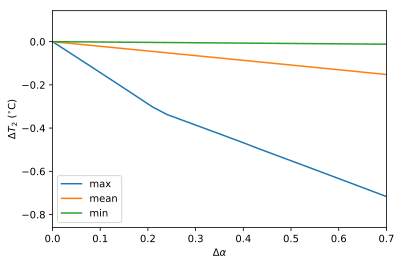

In [32]:
ax_temp_diff = df_res_alb_T2_diff.loc[['max', 'mean', 'min']].T.plot()
ax_temp_diff.set_ylabel('$\Delta T_2$ ($^{\circ}}$C)')
ax_temp_diff.set_xlabel(r'$\Delta\alpha$')
ax_temp_diff.margins(x=0.2, y=0.2)

## Background climate: air temperature

### Examine the monthly climatology of air temperature loaded from the sample dataset

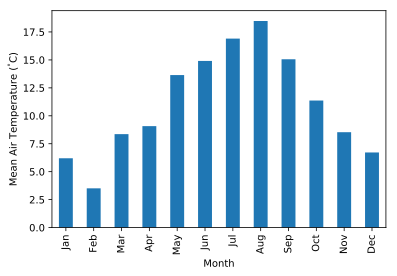

In [3]:
df_plot = df_forcing.Tair.iloc[:-1].resample('1m').mean()
ax_temp = df_plot.plot.bar(color='tab:blue')
ax_temp.set_xticklabels(df_plot.index.strftime('%b'))
ax_temp.set_ylabel('Mean Air Temperature ($^\degree$C)')
ax_temp.set_xlabel('Month')
ax_temp


### Construct a function to perform parallel `supy` simulation with specified `diff_airtemp_test`: the difference in air temperature between the one used in simulation and loaded from sample dataset.
*Note: forcing data `df_forcing` has different data structure from `df_state_init`; so we need to modify `run_supy_mgrids` to implement a `run_supy_mclims` for different climate scenarios*

Let's start the implementation of `run_supy_mclims` with a small problem of four forcing groups (i.e., climate scenarios), where the air temperatures differ from the baseline scenario with a constant bias.

In [4]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

In [5]:
# create a dict with four forcing conditions as a test
n_test = 4
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

dd_forcing_x = {
    k: delayed(sp.run_supy)(df, df_state_init_test)[0]
    for k, df in dict_df_forcing_x.items()}


df_res_tairdiff_test0 = delayed(pd.concat)(
    dd_forcing_x,
    keys=list_TairDiff_test,
    names=['tairdiff'],
)

In [6]:
# test the performance of a parallel run
t0 = time()
df_res_tairdiff_test = df_res_tairdiff_test0\
    .compute(scheduler='processes')\
    .reset_index('grid', drop=True)
t1 = time()
t_par = t1 - t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 31.86 s


In [7]:
# function for multi-climate `run_supy`
# wrapping the above code into one
def run_supy_mclims(df_state_init, dict_df_forcing_mclims):
    dd_forcing_x = {
        k: delayed(sp.run_supy)(df, df_state_init_test)[0]
        for k, df in dict_df_forcing_x.items()}
    df_output_mclims0 = delayed(pd.concat)(
        dd_forcing_x,
        keys=list(dict_df_forcing_x.keys()),
        names=['clm'],
    ).compute(scheduler='processes')
    df_output_mclims = df_output_mclims0.reset_index('grid', drop=True)

    return df_output_mclims

### Construct `dict_df_forcing_x` with multiple forcing `DataFrame`s

In [23]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

# create a dict with a number of forcing conditions
n_test = 24 # can be set with a smaller value to save simulation time
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

### Perform simulations

In [24]:
# run parallel simulations using `run_supy_mclims`
t0 = time()
df_airtemp_test_x = run_supy_mclims(df_state_init_test, dict_df_forcing_x)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 126.18 s


### Examine the results

In [25]:
df_airtemp_test = df_airtemp_test_x.SUEWS.unstack(0)
df_temp_diff=df_airtemp_test.T2.transform(lambda x: x - df_airtemp_test.T2[0.0])
df_temp_diff_ana=df_temp_diff.loc['2012 7']
df_temp_diff_stat=df_temp_diff_ana.describe().loc[['max', 'mean', 'min']].T

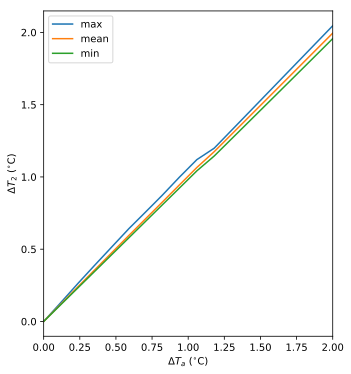

In [26]:
ax_temp_diff_stat=df_temp_diff_stat.plot()
ax_temp_diff_stat.set_ylabel('$\\Delta T_2$ ($^{\\circ}}$C)')
ax_temp_diff_stat.set_xlabel('$\\Delta T_{a}$ ($^{\\circ}}$C)')
ax_temp_diff_stat.set_aspect('equal')